In [1]:
%%capture
pip install pennylane jax jaxlib

In [2]:
import pennylane as qml
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import jax
from jax import numpy as jnp
import optax
import matplotlib.pyplot as plt

## Fashion MNIST

In [3]:
# Define the transformation to reduce the images to 16x16 pixels
transform = transforms.Compose([transforms.Resize((16, 16)), transforms.ToTensor()])

# Load the original datasets with the applied transformation
mnist_trainset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

# Filter indices to only include digits 0 and 1
train_indices = [i for i, (x, y) in enumerate(mnist_trainset) if y in [0, 1]]
test_indices = [i for i, (x, y) in enumerate(mnist_testset) if y in [0, 1]]

# Reduce the size of the subsets
train_size = 10000
test_size = 2000

train_indices = train_indices[:train_size]
test_indices = test_indices[:test_size]

# Create subsets with the filtered indices
mnist_trainset_small = Subset(mnist_trainset, train_indices)
mnist_testset_small = Subset(mnist_testset, test_indices)

# Convert the data to tensors for training and testing
X_train = torch.stack([item[0] for item in mnist_trainset_small])
y_train = torch.tensor([item[1] for item in mnist_trainset_small])
X_train = X_train.reshape(10000, 16, 16, 1)

X_test = torch.stack([item[0] for item in mnist_testset_small])
y_test = torch.tensor([item[1] for item in mnist_testset_small])
X_test = X_test.reshape(2000, 16, 16, 1)

# Check the shape of the training and test sets
X_train.shape, X_test.shape

100%|██████████| 26421880/26421880 [00:08<00:00, 3140428.67it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203376.52it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 930037.87it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18038660.81it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



(torch.Size([10000, 16, 16, 1]), torch.Size([2000, 16, 16, 1]))

In [4]:
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.IsingZZ(phi[2], wires=wires)
    qml.RX(phi[3], wires=wires[0])
    qml.RX(phi[4], wires=wires[1])
    qml.IsingYY(phi[5], wires=wires)


def Pooling_ansatz(phi, wires):
    qml.RX(phi[0], wires=wires[0])
    qml.RX(phi[1], wires=wires[1])
    qml.RY(phi[2], wires=wires[1])
    qml.RZ(phi[3], wires=wires[1])
    qml.CRX(phi[4], wires=[wires[1], wires[0]])


def qcnn_full(params, wires):
    # 14 params
    for i in range(int(len(wires) / 2)):
        U2(params[:6], [wires[2 * i], wires[2 * i + 1]])
    U2(params[:6], [wires[1], wires[2]])
    U2(params[:6], [wires[5], wires[6]])
    U2(params[:6], [wires[0], wires[3]])
    U2(params[:6], [wires[4], wires[7]])

    qml.Barrier()
    for i in range(int(len(wires) / 2)):
        Pooling_ansatz(params[9:14], [wires[2 * i], wires[2 * i + 1]])

    qml.Barrier()

(<Figure size 2200x900 with 1 Axes>, <Axes: >)

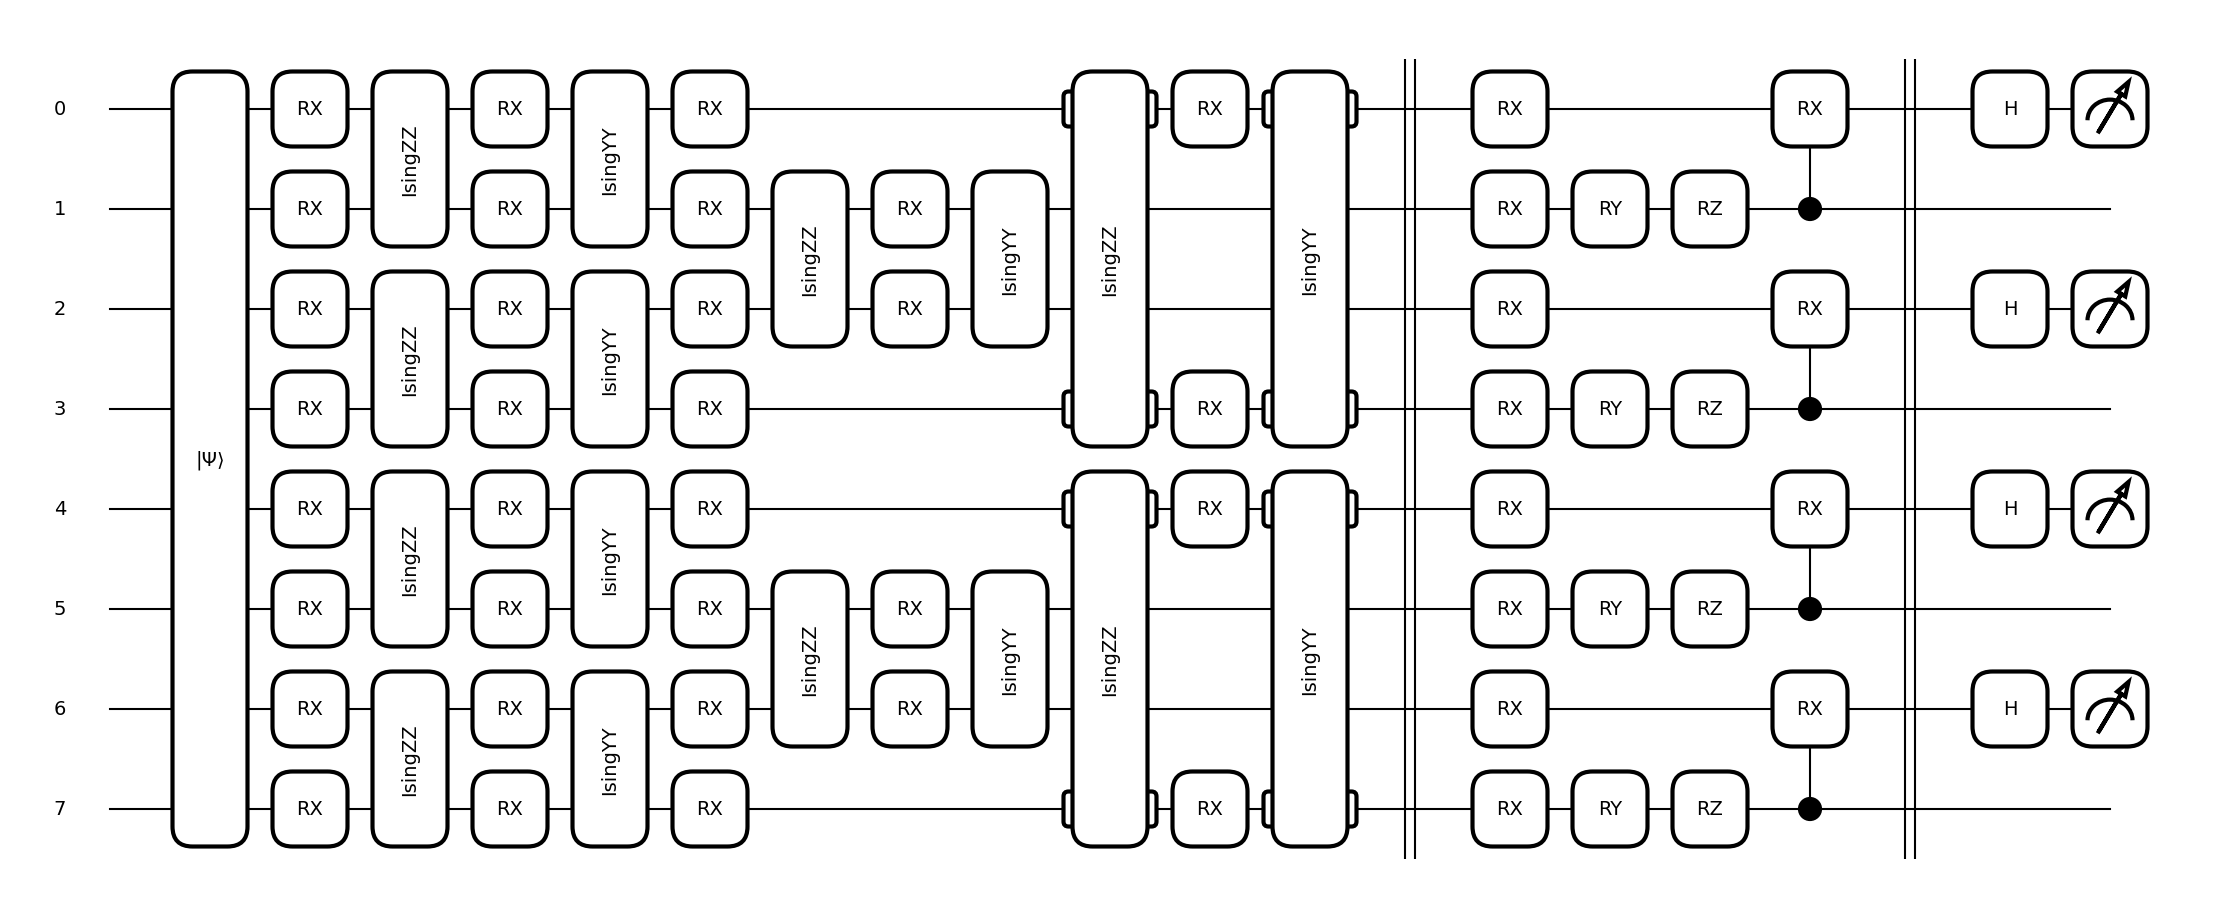

In [5]:
params = np.ones(22)
matrix = np.array(X_train[0])
matrix_reflected = np.fliplr(matrix)
num_qubits = 8

dev = qml.device("default.qubit", wires=num_qubits)


@qml.qnode(dev)
def qnode(inputs, params):
    qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), normalize=True)
    qcnn_full(params, [0, 1, 2, 3, 4, 5, 6, 7])
    qml.Hadamard(0)
    qml.Hadamard(2)
    qml.Hadamard(4)
    qml.Hadamard(6)
    return qml.probs(wires=[0, 2, 4, 6])


def draw_circuit(matrix, params):
    matrix_np = np.array(matrix)
    params_np = np.array(params)

    @qml.qnode(dev)
    def temp_circuit():
        qml.AmplitudeEmbedding(matrix, wires=range(num_qubits), normalize=True)
        qcnn_full(params_np, [0, 1, 2, 3, 4, 5, 6, 7])
        qml.Hadamard(0)
        qml.Hadamard(2)
        qml.Hadamard(4)
        qml.Hadamard(6)
        return qml.probs(wires=[0, 2, 4, 6])

    return qml.draw_mpl(temp_circuit)()


# Draw the circuit
draw_circuit(matrix.reshape(16 * 16), params)

Now, we can test that this quantum circuit is invariant under reflections over X and Y axis.

 Output with Probabilities for Original Image: [0.08990438 0.0966284  0.02869888 0.18327976 0.01771794 0.01117208
 0.01715135 0.03280559 0.01301157 0.03114778 0.01264262 0.02383751
 0.10973951 0.09478242 0.03399952 0.20348074]
 Output with Probabilities for Image Reflected over Y-axis: [0.08990438 0.0966284  0.02869888 0.18327976 0.01771794 0.01117208
 0.01715135 0.03280559 0.01301157 0.03114778 0.01264262 0.02383751
 0.10973951 0.09478242 0.03399952 0.20348074]
 Output with Probabilities for Image Reflected over X-axis: [0.08990438 0.0966284  0.02869888 0.18327976 0.01771794 0.01117208
 0.01715135 0.03280559 0.01301157 0.03114778 0.01264262 0.02383751
 0.10973951 0.09478242 0.03399952 0.20348074]


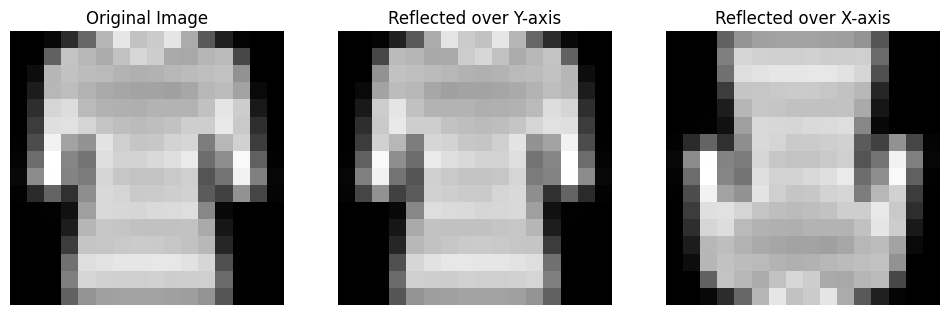

In [6]:
import matplotlib.pyplot as plt

matrix = np.array(X_train[7])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# array to JAX
matrix_reflected_y_jax = np.array(matrix_reflected_y).reshape(16 * 16)
matrix_reflected_x_jax = np.array(matrix_reflected_x).reshape(16 * 16)


result1 = qnode(matrix.reshape(16 * 16), params)
result2 = qnode(matrix_reflected_y_jax, params)
result3 = qnode(matrix_reflected_x_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")

# Plot the images in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns, adjustable size

# Show the original image
axes[0].imshow(matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show the image reflected over the Y-axis
axes[1].imshow(matrix_reflected_y, cmap="gray")
axes[1].set_title("Reflected over Y-axis")
axes[1].axis("off")

# Show the image reflected over the X-axis
axes[2].imshow(matrix_reflected_x, cmap="gray")
axes[2].set_title("Reflected over X-axis")
axes[2].axis("off")

# Display the images
plt.show()

In [7]:
output = qnode(matrix.reshape(16 * 16), params)
output.shape

(16,)

In [8]:
weight_shapes = {"params": (93,)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

clayer_1 = torch.nn.Linear(16, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [qlayer, clayer_1, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [9]:
# print total number of params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# print number of params per layer
print(model[1].parameters())  # Pesos de la primera capa

Total trainable parameters: 127
<generator object Module.parameters at 0x798ebdb64900>


<ipython-input-10-033c5a4f5ae2>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_tensor = torch.tensor(


Output with probabilities for the original image: tensor([[0.5229, 0.4771]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the Y-axis: tensor([[0.5229, 0.4771]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the X-axis: tensor([[0.5229, 0.4771]], grad_fn=<SoftmaxBackward0>)


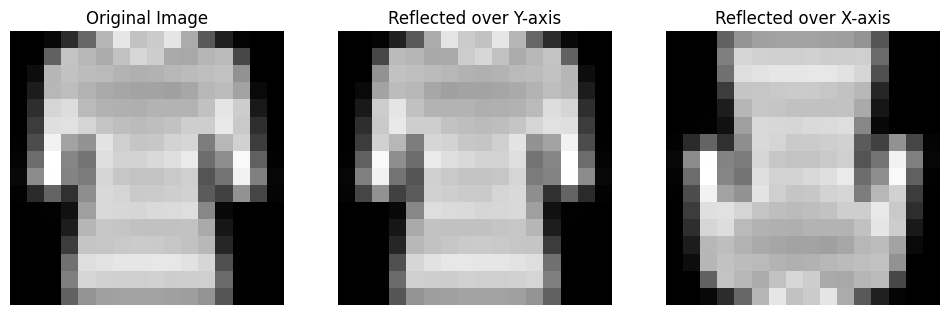

In [10]:
import torch
import matplotlib.pyplot as plt

# Select an image from the dataset
matrix = X_train[7]

# Reflect the image over the Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Reflect the image over the X-axis
matrix_reflected_x = np.flipud(matrix)

# Convert NumPy arrays to PyTorch tensors
matrix_tensor = torch.tensor(
    matrix.reshape(1, 16 * 16), dtype=torch.float32
)  # Convert the original image
matrix_reflected_y_tensor = torch.tensor(
    matrix_reflected_y.reshape(1, 16 * 16), dtype=torch.float32
)  # Reflected over Y
matrix_reflected_x_tensor = torch.tensor(
    matrix_reflected_x.reshape(1, 16 * 16), dtype=torch.float32
)  # Reflected over X

# Pass the tensors to the model
result1 = model(matrix_tensor)
result2 = model(matrix_reflected_y_tensor)
result3 = model(matrix_reflected_x_tensor)

# Display the results
print(f"Output with probabilities for the original image: {result1}")
print(f"Output with probabilities for the image reflected over the Y-axis: {result2}")
print(f"Output with probabilities for the image reflected over the X-axis: {result3}")

# Plot the images in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns, adjustable size

# Show the original image
axes[0].imshow(matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show the image reflected over the Y-axis
axes[1].imshow(matrix_reflected_y, cmap="gray")
axes[1].set_title("Reflected over Y-axis")
axes[1].axis("off")

# Show the image reflected over the X-axis
axes[2].imshow(matrix_reflected_x, cmap="gray")
axes[2].set_title("Reflected over X-axis")
axes[2].axis("off")

# Display the images
plt.show()

### model

In [ ]:
# import torch
# import torch.nn.functional as F

# # one-hot encoding
# num_classes = 2
# samples = 10000
# y_train_one_hot = F.one_hot(
#     y_train[:samples].to(torch.int64), num_classes=num_classes
# )  # Convert y_train to an integer tensor

# X = X_train[:samples].reshape(samples, 16 * 16).float().requires_grad_(True)
# y_hot = y_train_one_hot.long()


# batch_size = 64
# batches = samples // batch_size

# data_loader = torch.utils.data.DataLoader(
#     list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
# )

# epochs = 20

# for epoch in range(epochs):
#     running_loss = 0
#     for xs, ys in data_loader:
#         opt.zero_grad()
#         y_pred = model(xs)
#         loss_evaluated = loss(y_pred, ys)
#         loss_evaluated.backward()
#         opt.step()
#         running_loss += loss_evaluated.item()
#     avg_loss = running_loss / batches
#     print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

Average loss over epoch 1: 0.5015
Average loss over epoch 2: 0.5006
Average loss over epoch 3: 0.4969
Average loss over epoch 4: 0.4731
Average loss over epoch 5: 0.4395
Average loss over epoch 6: 0.4077
Average loss over epoch 7: 0.3775
Average loss over epoch 8: 0.3497
Average loss over epoch 9: 0.3247
Average loss over epoch 10: 0.3026
Average loss over epoch 11: 0.2833
Average loss over epoch 12: 0.2666
Average loss over epoch 13: 0.2517
Average loss over epoch 14: 0.2385
Average loss over epoch 15: 0.2269
Average loss over epoch 16: 0.2167
Average loss over epoch 17: 0.2077
Average loss over epoch 18: 0.1995
Average loss over epoch 19: 0.1926
Average loss over epoch 20: 0.1863


In [11]:
import torch
import torch.nn.functional as F
import torch.utils.data
import time
import csv

# Assuming model, opt, and loss are already defined

# Prepare train data
num_classes = 2
train_samples = 10000
y_train_one_hot = F.one_hot(
    y_train[:train_samples].to(torch.int64), num_classes=num_classes
)

X_train_reshaped = X_train[:train_samples].reshape(train_samples, 16 * 16).float().requires_grad_(True)
y_train_hot = y_train_one_hot.long()

# Prepare test data
test_samples = 2000
y_test_one_hot = F.one_hot(
    y_test[:test_samples].to(torch.int64), num_classes=num_classes
)

X_test_reshaped = X_test[:test_samples].reshape(test_samples, 16 * 16).float()
y_test_hot = y_test_one_hot.long()

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train_reshaped, y_train_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    list(zip(X_test_reshaped, y_test_hot)), batch_size=batch_size, shuffle=False
)

epochs = 20

# Initialize metrics
start_time = time.time()
final_train_accuracy = 0.0
final_test_accuracy = 0.0

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for xs, ys in train_loader:
        opt.zero_grad()
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated.item()

        _, predicted = torch.max(y_pred.data, 1)
        total += ys.size(0)
        correct += (predicted == torch.argmax(ys, dim=1)).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}: Avg Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    if epoch == epochs - 1:
        final_train_accuracy = train_accuracy

# Calculate training time
training_time = time.time() - start_time

# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0
start_time = time.time()
with torch.no_grad():
    for xs, ys in test_loader:
        outputs = model(xs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += ys.size(0)
        test_correct += (predicted == torch.argmax(ys, dim=1)).sum().item()

inference_time = time.time() - start_time
final_test_accuracy = 100 * test_correct / test_total

Epoch 1: Avg Loss: 0.4973, Train Accuracy: 57.27%
Epoch 2: Avg Loss: 0.4865, Train Accuracy: 83.68%
Epoch 3: Avg Loss: 0.4733, Train Accuracy: 90.08%
Epoch 4: Avg Loss: 0.4593, Train Accuracy: 91.21%
Epoch 5: Avg Loss: 0.4451, Train Accuracy: 90.77%
Epoch 6: Avg Loss: 0.4307, Train Accuracy: 90.87%
Epoch 7: Avg Loss: 0.4155, Train Accuracy: 91.12%
Epoch 8: Avg Loss: 0.3988, Train Accuracy: 91.24%
Epoch 9: Avg Loss: 0.3798, Train Accuracy: 91.41%
Epoch 10: Avg Loss: 0.3592, Train Accuracy: 91.54%
Epoch 11: Avg Loss: 0.3403, Train Accuracy: 91.37%
Epoch 12: Avg Loss: 0.3245, Train Accuracy: 91.43%
Epoch 13: Avg Loss: 0.3108, Train Accuracy: 91.48%
Epoch 14: Avg Loss: 0.2985, Train Accuracy: 91.48%
Epoch 15: Avg Loss: 0.2873, Train Accuracy: 91.42%
Epoch 16: Avg Loss: 0.2769, Train Accuracy: 91.46%
Epoch 17: Avg Loss: 0.2676, Train Accuracy: 91.41%
Epoch 18: Avg Loss: 0.2593, Train Accuracy: 91.35%
Epoch 19: Avg Loss: 0.2515, Train Accuracy: 91.31%
Epoch 20: Avg Loss: 0.2444, Train Accura

In [ ]:

# Prepare metrics for CSV
metrics = {
    'Optimizer': type(opt).__name__,
    'Learning_Rate': opt.param_groups[0]['lr'],
    'Weight_Decay': opt.param_groups[0]['weight_decay'],
    'Batch_Size': batch_size,
    'Epochs': epochs,
    'Loss_Function': type(loss).__name__,
    'Training_Subset_Size': f"{train_samples} ({train_samples/len(X_train)*100:.1f}% of full dataset)",
    'Training_Time': f"{training_time:.2f}",
    'Inference_Time': f"{inference_time:.2f}",
    'Final_Train_Accuracy': f"{final_train_accuracy:.2f}",
    'Final_Test_Accuracy': f"{final_test_accuracy:.2f}"
}

# Write metrics to CSV
csv_filename = 'fashion_mnist_metrics.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics have been saved to {csv_filename}")

In [ ]:
y_pred = model(X)

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train[:samples].numpy()).sum()
accuracy = correct / len(y_train[:samples])
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 93.82000000000001%


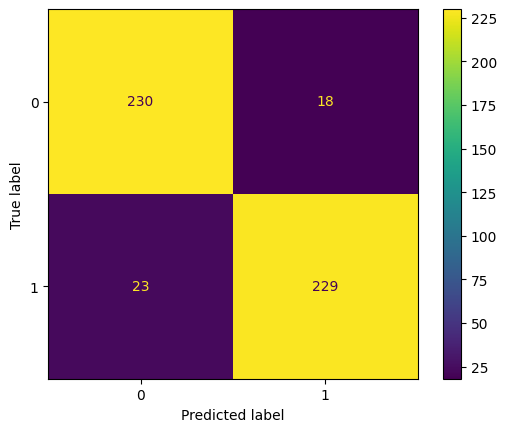

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_samples = 500
X_test = (
    X_test[:test_samples].reshape(test_samples, 16 * 16).float().requires_grad_(True)
)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test[:test_samples], y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()